In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

IndexError: list index out of range

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob

from scipy.signal import find_peaks

from deepposekit.models import load_model
from deepposekit.io import DataGenerator, VideoReader, VideoWriter
from deepposekit.io.utils import merge_new_images

import tqdm
import time



# Load model

In [4]:
model = load_model('dataset/best_model_densenet_2.h5')

# Test model

In [5]:
reader = VideoReader('dataset/0XKH.mp4', batch_size=10, gray=True)
frames = reader[0]
reader.close()

True

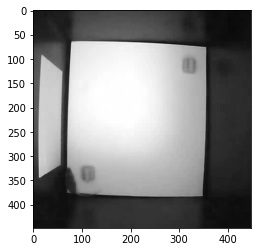

In [6]:
plt.imshow(frames[0,...,0], cmap='gray')
plt.show()

In [33]:
reader = VideoReader('dataset/m2t2.mp4', batch_size=8, gray=True)
predictions = model.predict(reader, verbose=1)
reader.close()

3752/3752 [==============================] - 805s 214ms/step


True

In [ ]:
np.save('dataset/predictions.npy', predictions)

In [20]:
x, y, confidence = np.split(predictions, 3, -1)

In [21]:
predictions[0]

array([[352.4       ,  78.880005  ,   0.9405146 ],
       [341.04      ,  77.84      ,   0.69911283],
       [309.68      ,  71.600006  ,   0.8491651 ]], dtype=float32)

In [22]:
x[0]

array([[352.4 ],
       [341.04],
       [309.68]], dtype=float32)

C:\Users\Yixiong\Anaconda3\envs\deeppose\lib\site-packages\deepposekit\io\DataGenerator.py:81: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.annotated = np.all(h5file["annotated"].value, axis=1)


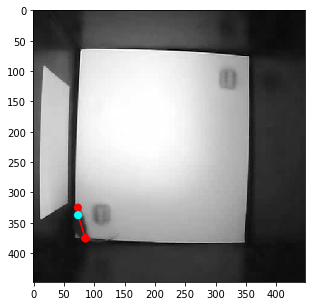

In [23]:
data_generator = DataGenerator('dataset/example_annotation_set.h5')
predictions = np.load('dataset/predictions.npy')

image = frames[0]
keypoints = predictions[0]

plt.figure(figsize=(5,5))
image = image if image.shape[-1] is 3 else image[..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1:
        plt.plot(
            [keypoints[idx, 0], keypoints[jdx, 0]],
            [keypoints[idx, 1], keypoints[jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[:, 0], keypoints[:, 1],
            c=np.arange(data_generator.keypoints_shape[0]),
            s=50, cmap=plt.cm.hsv, zorder=3)
plt.scatter(keypoints[2, 0], keypoints[2, 1],
            c=1,
            s=50, cmap=plt.cm.hsv, zorder=3)
plt.show()

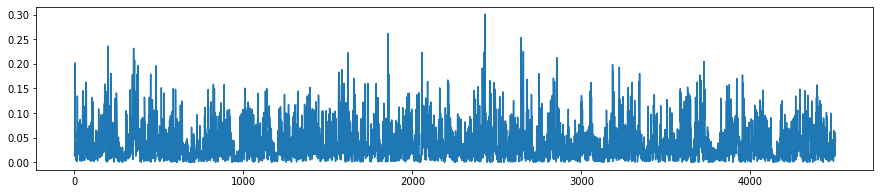

In [24]:
confidence_diff = np.abs(np.diff(confidence.mean(-1).mean(-1)))

plt.figure(figsize=(15, 3))
plt.plot(confidence_diff)
plt.show()

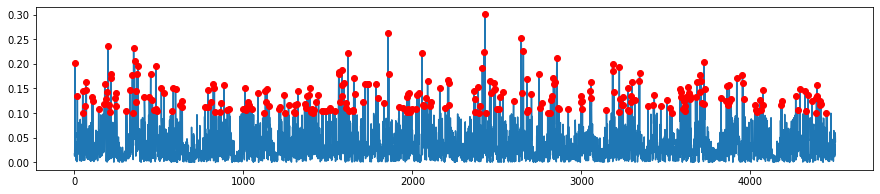

In [25]:
confidence_outlier_peaks = find_peaks(confidence_diff, height=0.1)[0]

plt.figure(figsize=(15, 3))
plt.plot(confidence_diff)
plt.plot(confidence_outlier_peaks, confidence_diff[confidence_outlier_peaks], 'ro')
plt.show()

In [26]:
time_diff = np.diff(predictions[..., :2], axis=0)
time_diff = np.abs(time_diff.reshape(time_diff.shape[0], -1))
time_diff = time_diff.mean(-1)
time_diff.shape

(7512,)

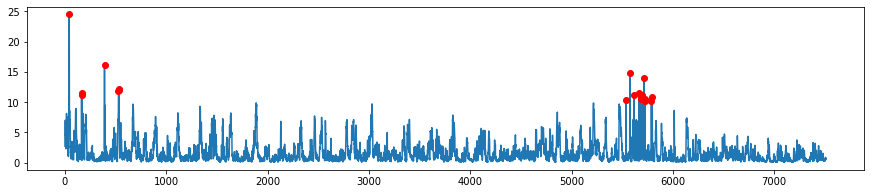

In [27]:
time_diff_outlier_peaks = find_peaks(time_diff, height=10)[0]

plt.figure(figsize=(15, 3))
plt.plot(time_diff)
plt.plot(time_diff_outlier_peaks, time_diff[time_diff_outlier_peaks], 'ro')
plt.show()

In [28]:
outlier_index = np.concatenate((confidence_outlier_peaks, time_diff_outlier_peaks))
outlier_index = np.unique(outlier_index) # make sure there are no repeats

In [29]:
reader = VideoReader('dataset/0XKH.mp4', batch_size=1, gray=True)

outlier_images = []
outlier_keypoints = []
for idx in outlier_index:
    outlier_images.append(reader[idx])
    outlier_keypoints.append(predictions[idx])

outlier_images = np.concatenate(outlier_images)
outlier_keypoints = np.stack(outlier_keypoints)

reader.close()

outlier_images.shape, outlier_keypoints.shape

((301, 448, 448, 1), (301, 3, 3))

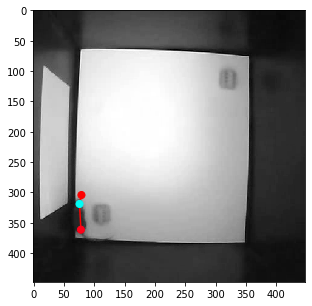

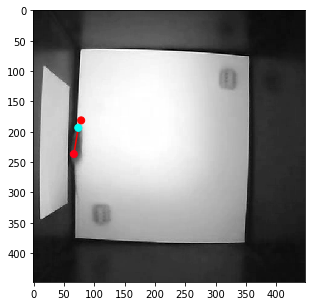

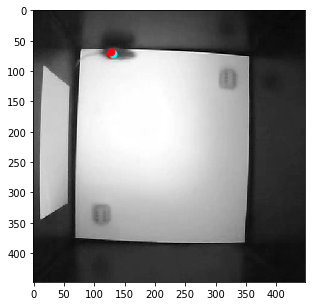

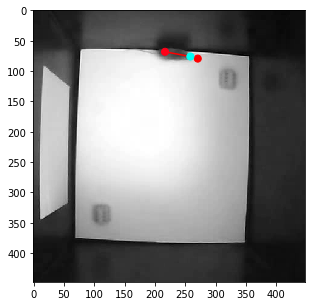

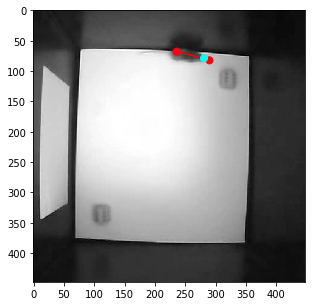

In [30]:
for idx in range(5):
    image = outlier_images[idx]
    keypoints = outlier_keypoints[idx]

    plt.figure(figsize=(5,5))
    image = image if image.shape[-1] is 3 else image[..., 0]
    cmap = None if image.shape[-1] is 3 else 'gray'
    plt.imshow(image, cmap=cmap, interpolation='none')
    for idx, jdx in enumerate(data_generator.graph):
        if jdx > -1:
            plt.plot(
                [keypoints[idx, 0], keypoints[jdx, 0]],
                [keypoints[idx, 1], keypoints[jdx, 1]],
                'r-'
            )
    plt.scatter(keypoints[:, 0], keypoints[:, 1],
                c=np.arange(data_generator.keypoints_shape[0]),
                s=50, cmap=plt.cm.hsv, zorder=3)

    plt.show()

In [31]:
merge_new_images(
    datapath='dataset/annotation_merged_2.h5',
    merged_datapath='dataset/annotation_merged_3.h5',
    images=outlier_images,
    keypoints=outlier_keypoints,
    # overwrite=True # This overwrites the merged dataset if it already exists
)

C:\Users\Yixiong\Anaconda3\envs\deeppose\lib\site-packages\deepposekit\io\DataGenerator.py:81: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.annotated = np.all(h5file["annotated"].value, axis=1)


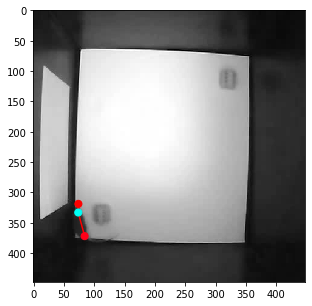

In [32]:
merged_generator = DataGenerator('dataset/annotation_merged.h5', mode="unannotated")

image, keypoints = merged_generator[0]

plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1:
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, :, 0], keypoints[0, :, 1], c=np.arange(data_generator.keypoints_shape[0]), s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()

In [10]:
predictions = np.load('dataset/predictions.npy')
predictions = predictions[...,:2]
predictions *= 2
data_generator = DataGenerator('dataset/example_annotation_set.h5')

resized_shape = (data_generator.image_shape[0]*2, data_generator.image_shape[1]*2)
cmap = plt.cm.hsv(np.linspace(0, 1, data_generator.keypoints_shape[0]))[:, :3][:, ::-1] * 255

writer = VideoWriter('pred.mp4', (192*2,192*2), 'MP4V', 30.0)
reader = VideoReader('dataset/0XKH.mp4', batch_size=1, gray=True)

for frame, keypoints in tqdm.tqdm(zip(reader, predictions)):
    frame = frame[0]
    frame = frame.copy()
    frame = cv2.resize(frame, resized_shape)
    for idx, node in enumerate(data_generator.graph):
        if node >= 0:
            pt1 = keypoints[idx]
            pt2 = keypoints[node]

            cv2.line(frame, (int(pt1[0]), int(pt1[1])), (int(pt2[0]), int(pt2[1])), (0,0,255), 2, cv2.LINE_AA)
    for idx, keypoint in enumerate(keypoints):
        keypoint = keypoint.astype(int)
        cv2.circle(frame, (keypoint[0], keypoint[1]), 5, tuple(cmap[idx]), -1, lineType=cv2.LINE_AA)
        
    writer.write(frame)

writer.close()
reader.close()

7513it [00:06, 1076.73it/s]


True

In [19]:
predictions

array([[[146.4    , 650.4    ],
        [147.04001, 675.36   ],
        [170.56   , 751.52   ]],

       [[148.     , 638.08   ],
        [147.52002, 666.56   ],
        [168.48001, 744.48   ]],

       [[151.36002, 625.12   ],
        [148.48001, 656.32   ],
        [161.44   , 736.8    ]],

       ...,

       [[488.8    , 188.95999],
        [519.68   , 181.76001],
        [566.08   , 164.48001]],

       [[490.4    , 192.48001],
        [518.56   , 183.20001],
        [565.76   , 164.     ]],

       [[492.96   , 192.64   ],
        [520.     , 185.44   ],
        [565.92   , 162.72   ]]], dtype=float32)

In [21]:
data_generator.graph

array([-1,  0,  1])